In [11]:
import sys

sys.tracebacklimit = None
from pathlib import Path

import numpy as np
from tb_hamiltonian import TightBindingHamiltonian
from tb_hamiltonian.potentials import PotentialFactory
from tb_hamiltonian.utils import get_structure

# Parameters & constants

In [12]:
lx = 500  # length in x direction (Å)
ly = lx / np.sqrt(3)  # length in y direction (Å) keeping the b/a ratio
lz = 10 # length in z direction (Å)
nn = 1  # number of nearest neighbors | don't use 0!

basepath = Path(f"new_tests/BLG/len_{lx}x{int(ly)}/nn_{nn}")
basepath.mkdir(parents=True, exist_ok=True)

neighbor_distances = (0.0, 1.425, 2.468, 2.850) # (Å)
hopping_parameters = (0.0, -2.7, 0.0, -0.27) # eV
interlayer_coupling = 0.33 # eV
onsite = -0.005 # eV

potential = PotentialFactory("triangular")
potential_amplitude = 0.01 # eV
potential_width = 0.125  # 0.1 | 0.125 | 0.25 | 0.5 | 1.0
potential_height = 2.0 * potential_width # eV
potential_ratio = (1.0, 0.3)

# Define structure

In [13]:
structure = get_structure(
    unit_cell_filepath=Path("new_tests/BLG/POSCAR"),  # local unit cell file
    lengths=(lx, ly, lz),
)

structure.info["label"] = "BLG"  # will show up at top of Hamiltonian output file

structure.write(basepath / "POSCAR", format="vasp")

# Compute H

In [14]:

H = TightBindingHamiltonian(
    structure=structure,
    nearest_neighbor=nn,
    distances=neighbor_distances,
    hopping_parameters=hopping_parameters,
    interlayer_coupling=interlayer_coupling,
)

H.build()

# Apply onsite term

In [15]:
potential.params = {
    "amplitude": potential_amplitude,
    "width": potential_width,
    "height": potential_height,  # twice the width if maintaining non-standard unit cell b/a ratio
}
H.update_onsite_terms(
    onsite_term=onsite,
    potential=potential,
    alpha=potential_ratio,
)

path = (
    basepath
    / f"{potential.name}"
    / f"amplitude_{potential.params['amplitude']}"
    / f"width_{potential.params['width']}"
)
path.mkdir(parents=True, exist_ok=True)

# Write H to file

In [16]:
H.write_to_file(path)

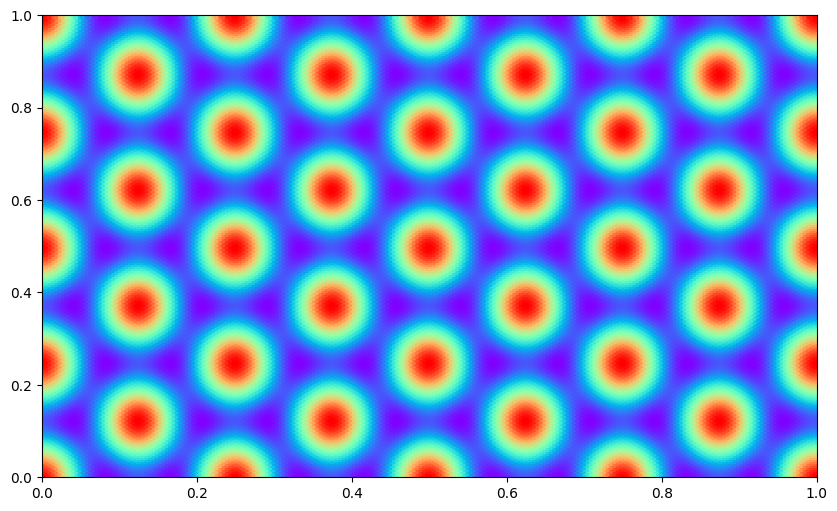

In [17]:
import matplotlib.pyplot as plt


def apply_potential(params: dict, coordinates: np.ndarray) -> float:
    amplitude = params.get("amplitude", 1.0)
    width = params.get("width", 1.0)
    height = params.get("height", 1.0)
    n = params.get("n", 1)
    m = params.get("m", 1)
    x, y, _ = coordinates
    kx1 = 2 * np.pi * n / width
    ky1 = 2 * np.pi * m / height  # factor of 2 works only if b/a ratio is maintained

    return amplitude * (
        np.cos(kx1 * x) + np.cos(kx1 / 2 * x + ky1 * y) + np.cos(kx1 / 2 * x - ky1 * y)
    )


frac = structure.get_scaled_positions()
n = int(len(structure) // 2)
x_frac = frac[:, 0]
y_frac = frac[:, 1]
z_frac = frac[:, 2]
coords = np.array([x_frac, y_frac, z_frac]).T
width = potential_width  # 0.1 | 0.125 | 0.25 | 0.5 | 1.0
params = {
    "amplitude": 1.0,
    "width": width,
    "height": width * 2,
}
V = np.array([apply_potential(params, c) for c in coords])

plt.figure(figsize=(10, 6))

# plot the potential
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
coords = np.array([X.flatten(), Y.flatten(), np.zeros_like(X.flatten())]).T
Z = np.array([apply_potential(params, c) for c in coords]).reshape(X.shape)
plt.contour(X, Y, Z, levels=250, cmap="rainbow", alpha=0.1, zorder=0)

# plot the bonds (slow!!!)
# distances = np.sqrt(
#     (x_frac[:n, np.newaxis] - x_frac[np.newaxis, :n]) ** 2
#     + (y_frac[:n, np.newaxis] - y_frac[np.newaxis, :n]) ** 2
# )
# indices = np.where((distances <= 0.03) & (distances > 0))
#
# for i, j in zip(indices[0], indices[1]):
#     plt.plot([x_frac[i], x_frac[j]], [y_frac[i], y_frac[j]], "k-", lw=0.5, zorder=1)

# plot the atoms
plt.scatter(x_frac[:n], y_frac[:n], s=10, c=V[:n], cmap="rainbow", zorder=2)

plt.show()

# Sanity checks


In [18]:
# H.onsite_count()
# H.interaction_counts()

# Plotting

In [19]:
# H.plot_matrix()

In [20]:
# H.plot_grid()